---
**License**

 stats_dist_gauss

 Mon Jan 25 20:56:00 2020\
 Copyright  2021\
 Eduardo ...\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 stats_dist_gauss\
 Copyright (C) 2021 Sandro Dias Pinto Vitenti <vitenti@uel.br>


 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
import gi
gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from pylab import figure, cm
import numpy as np
import scipy.stats
from scipy.optimize import minimize
from IPython.display import HTML, display
import tabulate
from numcosmo_py.plotting.tools import confidence_ellipse

from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

%matplotlib inline

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
dim = 5
np.random.seed(seed=123)

p = np.random.random_sample((dim,))
print (p)

[0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


In [4]:
rng = Ncm.RNG.seeded_new (None, 123)

fmodel = Ncm.ModelMVND.new (dim)
fdata = Ncm.DataGaussCovMVND.new_full (dim, 0.1, 0.4, 10.0, -1.0, 1.0, rng)
fdata.props.use_norma = False
nps = 160
split_fraction = 0.6

mset = Ncm.MSet.new_array ([fmodel])
mset.param_set_all_ftype (Ncm.ParamType.FREE)
mset.prepare_fparam_map ()

mset.fparams_set_array (p)
mset.pretty_log ()

#----------------------------------------------------------------------------------
# Model[00000]:
#   - NcmModelMVND : MVND
#----------------------------------------------------------------------------------
# Model parameters
#   - mu_0[00]:  0.696469185597862   [FREE]
#   - mu_1[01]:  0.286139334950379   [FREE]
#   - mu_2[02]:  0.226851453564203   [FREE]
#   - mu_3[03]:  0.551314769082891   [FREE]
#   - mu_4[04]:  0.719468969785563   [FREE]


In [5]:
interps = []
interps_desc = []

kernel0 = Ncm.StatsDistKernelST.new(dim, 1.0)
interp0 = Ncm.StatsDistKDE.new(kernel0, Ncm.StatsDistCV.NONE)
interps.append(interp0)
interps_desc.append("KDE Cauchy")

kernel1 = Ncm.StatsDistKernelST.new(dim, 3.0)
interp1 = Ncm.StatsDistKDE.new(kernel1, Ncm.StatsDistCV.NONE)
interps.append(interp1)
interps_desc.append("KDE ST3")

kernel2 = Ncm.StatsDistKernelGauss.new(dim)
interp2 = Ncm.StatsDistKDE.new(kernel2, Ncm.StatsDistCV.NONE)
interps.append(interp2)
interps_desc.append("KDE Gauss")

kernel3 = Ncm.StatsDistKernelST.new(dim, 1.0)
interp3 = Ncm.StatsDistVKDE.new(kernel3, Ncm.StatsDistCV.NONE)
interps.append(interp3)
interps_desc.append("VKDE Cauchy")

kernel4 = Ncm.StatsDistKernelST.new(dim, 3.0)
interp4 = Ncm.StatsDistVKDE.new(kernel4, Ncm.StatsDistCV.NONE)
interps.append(interp4)
interps_desc.append("VKDE ST3")

kernel5 = Ncm.StatsDistKernelGauss.new(dim)
interp5 = Ncm.StatsDistVKDE.new(kernel5, Ncm.StatsDistCV.NONE)
interps.append(interp5)
interps_desc.append("VKDE Gauss")

In [6]:
m2lnp_train = []
theta_train = []
m2lnp_test = []
theta_test = []

for interp in interps:
    interp.reset()

for a in range (nps):
    v, N = fdata.gen (mset, None, None, rng)
    for interp in interps:
        interp.add_obs (v)
    m2lnp_train.append (fdata.m2lnL_val (mset))
    theta_train.append (v.dup_array ())

for a in range (10 * nps):
    v, N = fdata.gen (mset, None, None, rng)
    m2lnp_test.append (fdata.m2lnL_val (mset))
    theta_test.append (v.dup_array ())
    

m2lnp_train = np.array (m2lnp_train)
theta_train = np.array (theta_train)
m2lnp_test = np.array (m2lnp_test)
theta_test = np.array (theta_test)

fdata.y.set_array (p)
fdata.m2lnL_val (mset)

m2lnp_train_v = Ncm.Vector.new_array (m2lnp_train)
m2lnp_test_v = Ncm.Vector.new_array (m2lnp_test)

def m2lnL_val(va):
    mset.fparams_set_array(va)
    return fdata.m2lnL_val(mset)

In [7]:
for interp in interps:
    interp.set_cv_type(Ncm.StatsDistCV.SPLIT)
    interp.set_split_frac(split_fraction)
    interp.set_print_fit(False)

    interp.prepare_interp(m2lnp_train_v)
    calib_os = interp.get_over_smooth()

    print(
        "Calibrate interpolation with os = % 22.15g and rnorm = % 22.15g"
        % (calib_os, interp.get_rnorm())
    )

Calibrate interpolation with os =       1.98868941604249 and rnorm =       39.9032523900517
Calibrate interpolation with os =       1.74738626625393 and rnorm =       24.8884814387598
Calibrate interpolation with os =       1.29779500432369 and rnorm =       4.93807329010668
Calibrate interpolation with os =      0.321833500235521 and rnorm =       29.8663482374598
Calibrate interpolation with os =      0.255365024363811 and rnorm =       23.7333633533889
Calibrate interpolation with os =      0.149263665479212 and rnorm =       16.0587991375906


In [8]:
m2lnp_interps = []

for interp in interps:
    m2lnp_interp = []
    for theta in theta_test:
        m2lnp_interp.append(interp.eval_m2lnp(Ncm.Vector.new_array(theta)))
    m2lnp_interp = np.array(m2lnp_interp)

    m2lnp_interps.append(m2lnp_interp)

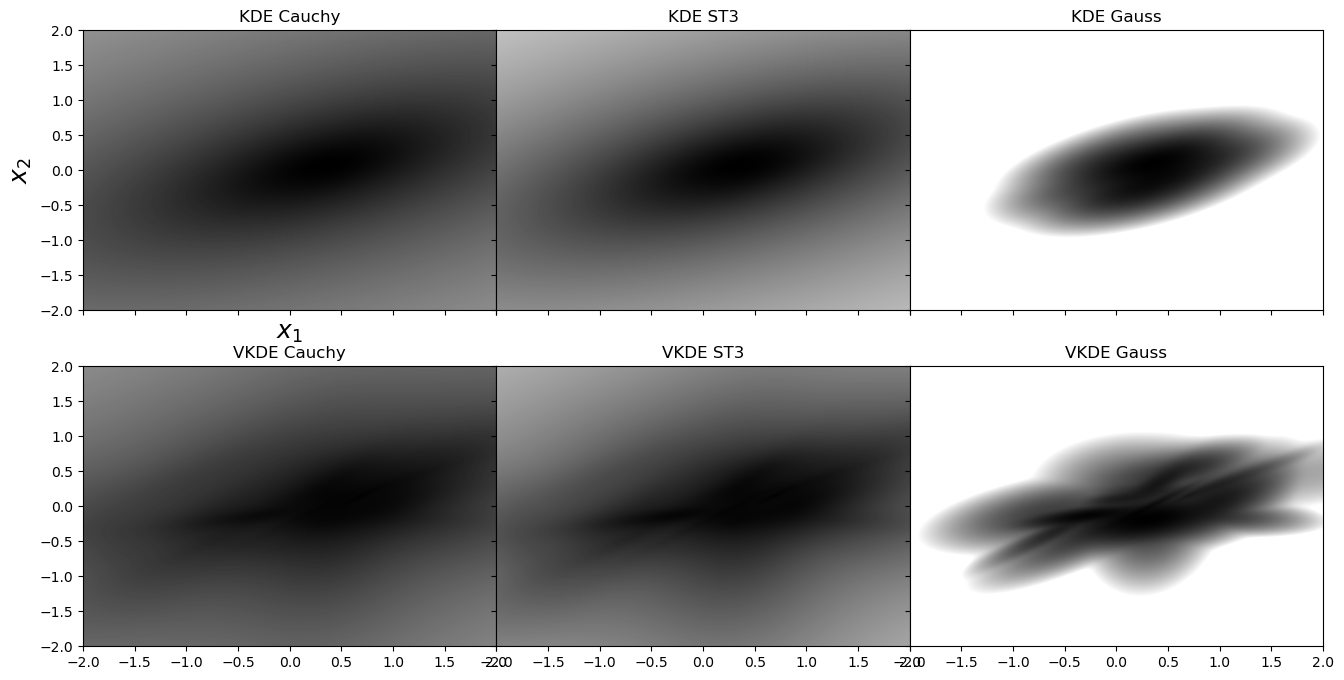

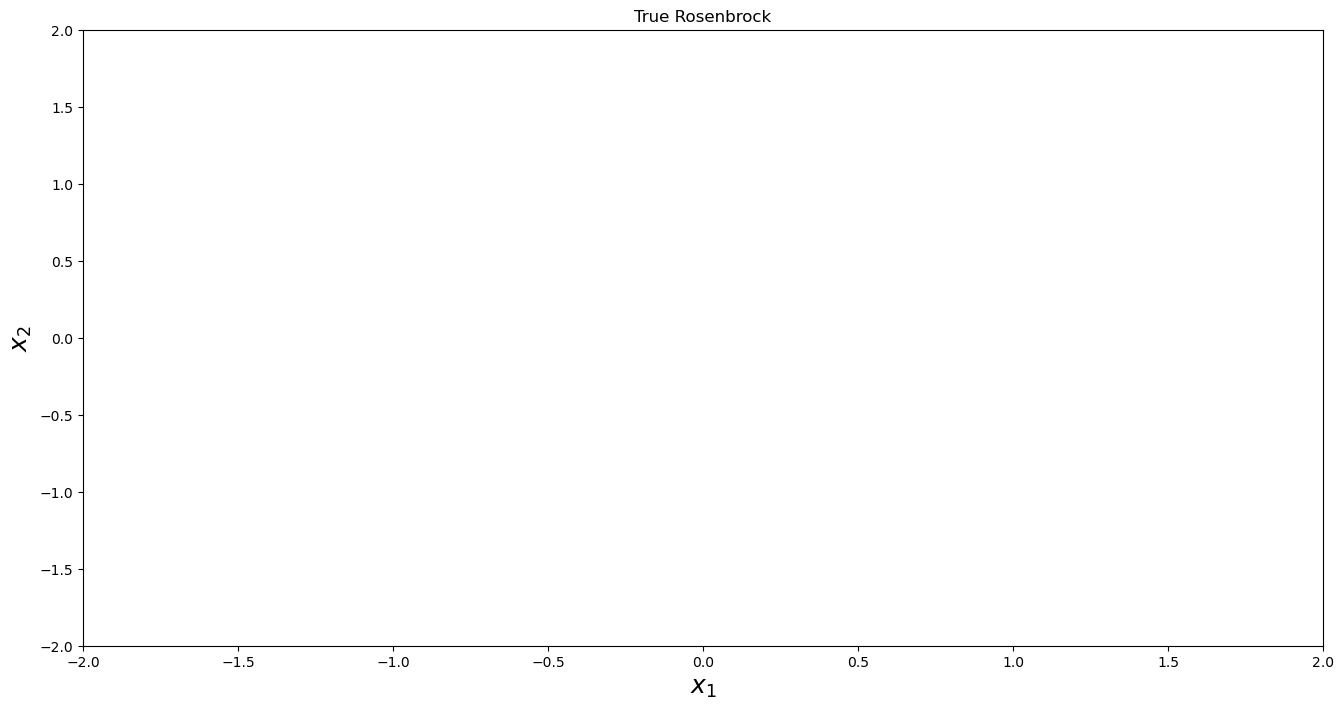

In [9]:
plotn = 150

fig, axa = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
axa = [ax for subaxa in axa for ax in subaxa]

theta0_test = theta_test[:,0]
theta1_test = theta_test[:,1]

x1_a = np.linspace(-2.0, 2.0, plotn)
x2_a = np.linspace(-2.0, 2.0, plotn)

for interp, interp_desc, ax0 in zip(interps, interps_desc, axa):

    z = np.array(
        [
            interp.eval_m2lnp(Ncm.Vector.new_array([x1, x2, 0.0, 0.0, 0.0]))
            for x2 in x2_a
            for x1 in x1_a
        ]
    )
    z = z - min(z)
    Z = z.reshape(plotn, plotn)

    ax0.imshow(
        Z,
        interpolation="bicubic",
        origin="lower",
        cmap=cm.gray,
        norm=Normalize(vmin=0.0, vmax=40),
        extent=[x1_a[0], x1_a[-1], x2_a[0], x2_a[-1]],
        aspect="auto",
    )
    ax0.set_title(interp_desc)
    if interp_desc == "KDE Cauchy":
        ax0.set_xlabel("$x_1$", fontsize=18)
        ax0.set_ylabel("$x_2$", fontsize=18)


plt.subplots_adjust(wspace=0.0, hspace=0.2)
plt.show()

plt.figure(figsize=(16, 8))

zT = np.array([m2lnL_val([x1, x2]) for x2 in x2_a for x1 in x1_a])
ZT = zT.reshape(plotn, plotn)
plt.imshow(
    ZT,
    interpolation="bicubic",
    origin="lower",
    cmap=cm.gray,
    norm=Normalize(vmin=0.0, vmax=40),
    extent=[x1_a[0], x1_a[-1], x2_a[0], x2_a[-1]],
    aspect="auto",
)
plt.title("True Rosenbrock")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18)

pass

In [10]:
table = [
    [
        "Interpolation type",
        "relative difference",
        "acceptance probability",
        "split fraction",
    ]
]

rel_diff_array = []
prob_array = []

for interp, interp_desc, m2lnp_interp in zip(interps, interps_desc, m2lnp_interps):

    p_test = np.exp(-0.5 * m2lnp_test)
    p_interp = np.exp(-0.5 * m2lnp_interp)

    log_diff = m2lnp_interp - m2lnp_test
    rel_diff = np.abs(np.expm1(-0.5 * log_diff))

    prob_ratio = -0.5 * (
        (m2lnp_interp[0::2] - m2lnp_test[0::2])
        - (m2lnp_interp[1::2] - m2lnp_test[1::2])
    )
    prob_ratio = np.clip(0, 10.0, prob_ratio)

    prob = np.minimum(np.exp(prob_ratio), 1.0)

    rel_diff_array.append(rel_diff)
    prob_array.append(prob)

    qp = [0.25, 0.75]

    q_rel_diff = np.quantile(rel_diff, qp) * 100.0
    q_prob = np.quantile(prob, qp) * 100.0

    line = [interp_desc]
    line.append("%.1f%% - %.1f%%" % (q_rel_diff[0], q_rel_diff[1]))
    line.append("%.1f%% - %.1f%%" % (q_prob[0], q_prob[1]))
    line.append("%.1f%%" % (split_fraction * 100.0))
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt="html")))

Interpolation type,relative difference,acceptance probability,split fraction
KDE Cauchy,50.0% - 76.4%,60.3% - 100.0%,60.0%
KDE ST3,24.7% - 61.0%,63.8% - 100.0%,60.0%
KDE Gauss,11.1% - 37.9%,75.1% - 100.0%,60.0%
VKDE Cauchy,50.4% - 80.1%,53.3% - 100.0%,60.0%
VKDE ST3,43.4% - 76.8%,51.7% - 100.0%,60.0%
VKDE Gauss,32.6% - 75.9%,46.9% - 100.0%,60.0%


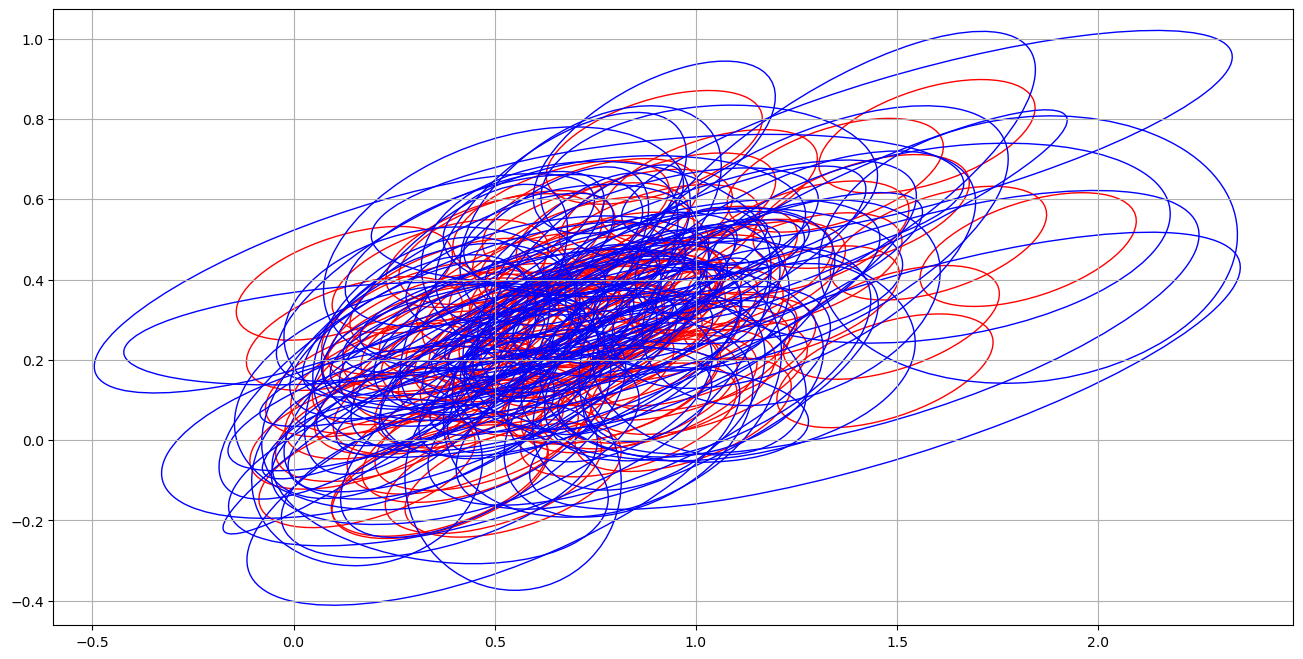

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i in range(0, interps[0].get_n_kernels()):
    y_i, cov_i, n_i, w_i = interps[0].get_Ki(i)
    mu = y_i.dup_array()
    cov = np.array([[cov_i.get(i, j) for j in range(2)] for i in range(2)])
    cov = cov * 1.0

    confidence_ellipse(mu, cov, ax, edgecolor="red")

for i in range(0, interps[3].get_n_kernels()):
    y_i, cov_i, n_i, w_i = interps[3].get_Ki(i)
    mu = y_i.dup_array()
    cov = np.array([[cov_i.get(i, j) for j in range(2)] for i in range(2)])
    cov = cov * 1.0

    confidence_ellipse(mu, cov, ax, edgecolor="blue")

ax.autoscale_view()
plt.grid()